In [1]:
# GPU Reset if needed

from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [2]:
# Parameters

base_directory = "i:/image_classify/" # base directory
original_images = "dataset_cleaned_part1" # original dataset directory
temp_base = "gender" # temporary dataset directory
image_directory = base_directory + temp_base # image directory for training and validation
dataset_names = ["type1_male", "type2_male", "type3_male", "type4_male","type1_female", "type2_female", "type3_female", "type4_female"] # class names to be classified into

image_size  = (224, 224) # preprocessing image size for model input to match with input_tensor in the model
classify_names = ["male", "female"] # class names to be classified into (same as sub folder names with images in different classes)

batch_size = 25 # number of images per batch to be processed

shuffle_value = True # whether to shuffle the input images
seed_value = 1337 # seed value to input image pipeline
epochs = 50 # number of maximum epochs to run

In [3]:
# Change to base directory

import os

os.chdir(base_directory)
print("base directory : " + os.getcwd())

base directory : i:\image_classify


In [4]:
# Create temporary dataset to train and test gender only

import shutil

try:
    shutil.rmtree(base_directory + temp_base,ignore_errors=True)
    os.makedirs(base_directory + temp_base, exist_ok=True)
   
    for names in classify_names:
        os.makedirs(base_directory + temp_base + "/" + names, exist_ok=True)

    for dataset in dataset_names:
        
        src = base_directory + original_images + "/" + dataset + "/"
        dst = base_directory + temp_base + "/"  + dataset.split("_")[1] + "/"
        print("Copying " + src + " to " + dst)
        for item in os.listdir(src):
            src_file = os.path.join(src, item)
            dst_file = os.path.join(dst, item)
            shutil.copy2(src_file, dst_file)
except:
    print("Error creating gender dataset")   

    

Copying i:/image_classify/dataset_cleaned_part1/type1_male/ to i:/image_classify/gender/male/
Copying i:/image_classify/dataset_cleaned_part1/type2_male/ to i:/image_classify/gender/male/
Copying i:/image_classify/dataset_cleaned_part1/type3_male/ to i:/image_classify/gender/male/
Copying i:/image_classify/dataset_cleaned_part1/type4_male/ to i:/image_classify/gender/male/
Copying i:/image_classify/dataset_cleaned_part1/type1_female/ to i:/image_classify/gender/female/
Copying i:/image_classify/dataset_cleaned_part1/type2_female/ to i:/image_classify/gender/female/
Copying i:/image_classify/dataset_cleaned_part1/type3_female/ to i:/image_classify/gender/female/
Copying i:/image_classify/dataset_cleaned_part1/type4_female/ to i:/image_classify/gender/female/


In [5]:
# Import Tensorflow and related libraries

import tensorflow

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AveragePooling2D

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate


from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

print("TensorFlow version : " + tensorflow.__version__)

TensorFlow version : 2.9.0-dev20220102


In [6]:
# Display available GPUs

physical_devices = tensorflow.config.list_physical_devices('GPU')
for gpu in physical_devices:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [7]:
# Enable Memory Growth

if physical_devices != []:
    tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)
    physical_devices[0]

In [8]:
# Create pipeline to load images

train_ds = tensorflow.keras.preprocessing.image_dataset_from_directory( # train image dataset
    image_directory,
    labels='inferred', 
    label_mode='int',
    class_names=classify_names,     
    validation_split=0.3,
    subset="training",
    shuffle=shuffle_value,
    seed=seed_value,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tensorflow.keras.preprocessing.image_dataset_from_directory( # validation image dataset
    image_directory,
    labels='inferred', 
    label_mode='int', 
    class_names=classify_names,    
    validation_split=0.3,
    subset="validation",
    shuffle=shuffle_value,
    seed=seed_value,
    image_size=image_size,
    batch_size=batch_size,
)



Found 26783 files belonging to 2 classes.
Using 18749 files for training.
Found 26783 files belonging to 2 classes.
Using 8034 files for validation.


In [9]:
# Train data augmentation to get more variations

data_augmentation = tensorflow.keras.Sequential(
    [
        tensorflow.keras.layers.experimental.preprocessing.RandomFlip("horizontal"), # horizontal flipping
        tensorflow.keras.layers.experimental.preprocessing.RandomRotation(0.1),     # random rotation
    ]
)

augmented_train_ds = train_ds.map( lambda x, y: (data_augmentation(x, training=True), y)) # get the augemted training data pipeline


Model: "gender"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                             

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

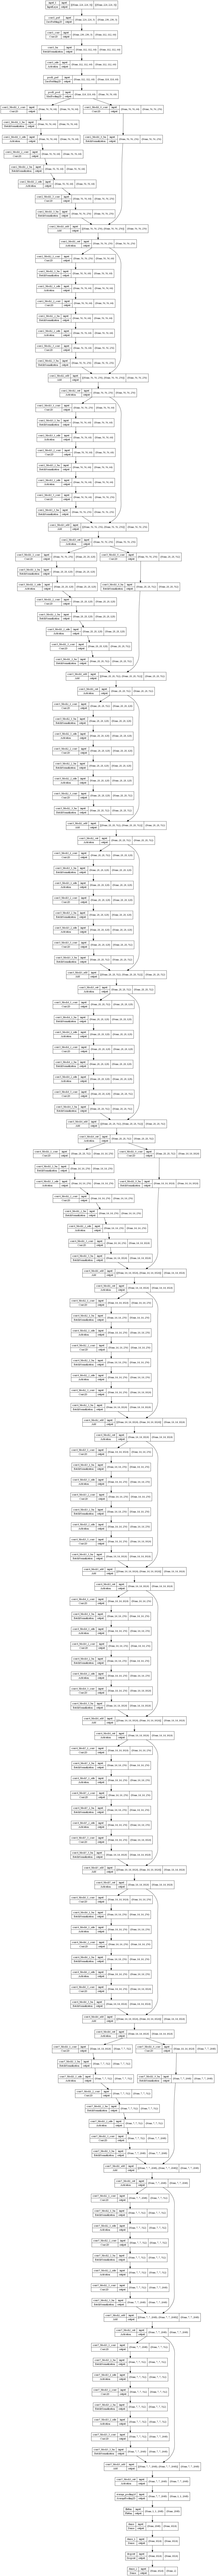

In [10]:
# Define model using ResNet50 and weights='imagenet'
from tensorflow.keras.applications import ResNet50

model = ResNet50(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

for layer in model.layers:
    layer.trainable = False    
    
    if layer.name == "conv5_block2_1_conv":
        layer.trainable = True
    if layer.name == "conv5_block2_1_bn":
        layer.trainable = True  
    if layer.name == "conv5_block2_1_relu":
        layer.trainable = True       
    if layer.name == "conv5_block2_2_conv":
        layer.trainable = True           
    if layer.name == "conv5_block2_2_bn":
        layer.trainable = True       
    if layer.name == "conv5_block2_2_relu":
        layer.trainable = True               
    if layer.name == "conv5_block2_3_conv":
        layer.trainable = True
    if layer.name == "conv5_block2_3_bn":
        layer.trainable = True  
    if layer.name == "conv5_block2_add":
        layer.trainable = True       
    if layer.name == "conv5_block2_out":
        layer.trainable = True       
    
    if layer.name == "conv5_block3_1_conv":
        layer.trainable = True
    if layer.name == "conv5_block3_1_bn":
        layer.trainable = True  
    if layer.name == "conv5_block3_1_relu":
        layer.trainable = True       
    if layer.name == "conv5_block3_2_conv":
        layer.trainable = True           
    if layer.name == "conv5_block3_2_bn":
        layer.trainable = True       
    if layer.name == "conv5_block3_2_relu":
        layer.trainable = True               
    if layer.name == "conv5_block3_3_conv":
        layer.trainable = True
    if layer.name == "conv5_block3_3_bn":
        layer.trainable = True  
    if layer.name == "conv5_block3_add":
        layer.trainable = True       
    if layer.name == "conv5_block3_out":
        layer.trainable = True     

avgpool1 = AveragePooling2D(pool_size=(7, 7))(model.layers[-1].output)
flat1 = Flatten()(avgpool1)
class1 = Dense(1024, activation='relu')(flat1)
class2 = Dense(1024, activation='relu')(class1)
dropout3 = Dropout(0.8)(class2)
output = Dense(2, activation='softmax')(dropout3)

# define new model
model = Model(inputs=model.inputs, outputs=output)

model._name = "gender"
model.summary()

# Save the model as a png file
plot_model(model, to_file=model._name +'.png', show_shapes=True, show_layer_names=True)

In [11]:
# Show the trainable status of the layers

for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [12]:
# Compile the model

model.compile(
    optimizer=tensorflow.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [13]:
# Tensorboard parameters

import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [14]:
# Use best weights for the model

early_stopping_monitor = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=6,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True
)

In [15]:
# Training the model

model.fit(
    augmented_train_ds, epochs=epochs, callbacks=[early_stopping_monitor, tensorboard_callback], validation_data=val_ds,
    )


Epoch 1/50
750/750 [==============================] - 255s 325ms/step - loss: 0.3783 - accuracy: 0.8551 - val_loss: 0.3787 - val_accuracy: 0.8554
Epoch 2/50
750/750 [==============================] - 239s 316ms/step - loss: 0.2606 - accuracy: 0.9053 - val_loss: 0.3970 - val_accuracy: 0.8641
Epoch 3/50
750/750 [==============================] - 240s 318ms/step - loss: 0.2158 - accuracy: 0.9224 - val_loss: 0.2640 - val_accuracy: 0.8992
Epoch 4/50
750/750 [==============================] - 239s 316ms/step - loss: 0.1826 - accuracy: 0.9343 - val_loss: 0.2164 - val_accuracy: 0.9231
Epoch 5/50
750/750 [==============================] - 241s 319ms/step - loss: 0.1547 - accuracy: 0.9459 - val_loss: 0.2779 - val_accuracy: 0.9101
Epoch 6/50
750/750 [==============================] - 251s 332ms/step - loss: 0.1278 - accuracy: 0.9532 - val_loss: 0.1929 - val_accuracy: 0.9282
Epoch 7/50
750/750 [==============================] - 240s 318ms/step - loss: 0.1119 - accuracy: 0.9606 - val_loss: 0.2329 -

In [16]:
# Show tensorboard

%load_ext tensorboard
%tensorboard --logdir logs/fit
#%reload_ext tensorboard # just in case tensorboard didn't refresh


In [17]:
# Calculate preditions for the validation dataset

import numpy as np

y_pred = []  # store predicted labels
y_true = []  # store true labels

for image_batch, label_batch in val_ds:
    y_true.append(label_batch)
    preds = model.predict(image_batch)
    y_pred.append(np.argmax(preds, axis = - 1))

# Convert the true and predicted labels into tensors
true_categories = tensorflow.concat([item for item in y_true], axis = 0)
predicted_categories = tensorflow.concat([item for item in y_pred], axis = 0)

In [18]:
# Generate confusion matrix

from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(true_categories,predicted_categories, normalize='pred')

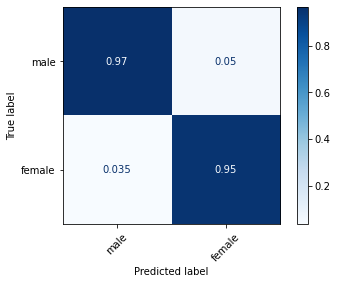

In [19]:
# Plot confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,
                              display_labels=classify_names)

disp = disp.plot(cmap='Blues', xticks_rotation=45)

plt.show()

In [20]:
# Display accuracy information

from sklearn.metrics import accuracy_score, f1_score

print("Accuracy for validation split: " ,accuracy_score(true_categories, predicted_categories))
print( "F1_score: " + str(f1_score(true_categories, predicted_categories, average='micro')))

Accuracy for validation split:  0.9621608165297486
F1_score: 0.9621608165297486


In [21]:
# Saving final model for future use

model.save("gender.h5")